In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='tensorflow' # Why theano why not
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 25000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

Using TensorFlow backend.


In [0]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [3]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [4]:
# reading data
df = pd.read_csv('/gdrive/My Drive/movie_review_small.csv',encoding = "ISO-8859-1")
df = df.dropna()
df = df.reset_index(drop=True)
print(df.shape)
print(len(set(df['CLASS'])))


(5002, 6)
2


In [0]:
macronum=sorted(set(df['CLASS']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

df['CLASS']=df['CLASS'].apply(fun)

In [6]:
texts = []
labels = []


for idx in range(df.CONTENT.shape[0]):
    text = BeautifulSoup(df.CONTENT[idx])
    texts.append(clean_str(str(text.get_text().encode())))


for idx in df['CLASS']:
    labels.append(idx)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [7]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(len(word_index))

13350


In [0]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [0]:
embeddings_index = {}
f = open('/gdrive/My Drive/glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


In [0]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [0]:
# To get f1 score
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(64, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(64, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(64, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(64, activation='relu')(l_flat)
preds = Dense(len(macronum), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['acc',f1])


cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=10, batch_size=2,callbacks=[cp])

Instructions for updating:
Use tf.cast instead.
Train on 4002 samples, validate on 1000 samples
Epoch 1/10
4002/4002 [==============================] - 15s 4ms/step - loss: 0.2524 - acc: 0.5305 - f1: 0.5305 - val_loss: 0.2878 - val_acc: 0.5070 - val_f1: 0.5070

Epoch 00001: val_acc improved from -inf to 0.50700, saving model to model_cnn.hdf5
Epoch 2/10
4002/4002 [==============================] - 11s 3ms/step - loss: 0.2477 - acc: 0.5555 - f1: 0.5555 - val_loss: 0.2440 - val_acc: 0.5700 - val_f1: 0.5700

Epoch 00002: val_acc improved from 0.50700 to 0.57000, saving model to model_cnn.hdf5
Epoch 3/10
4002/4002 [==============================] - 11s 3ms/step - loss: 0.2228 - acc: 0.6449 - f1: 0.6449 - val_loss: 0.2492 - val_acc: 0.5860 - val_f1: 0.5860

Epoch 00003: val_acc improved from 0.57000 to 0.58600, saving model to model_cnn.hdf5
Epoch 4/10
4002/4002 [==============================] - 12s 3ms/step - loss: 0.1803 - acc: 0.7271 - f1: 0.7271 - val_loss: 0.2531 - val_acc: 0.6100 - v

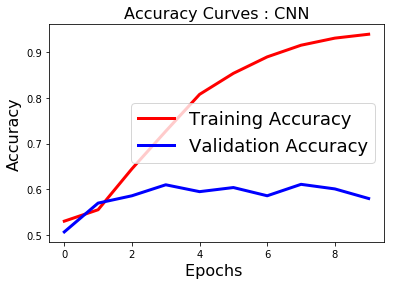

In [18]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

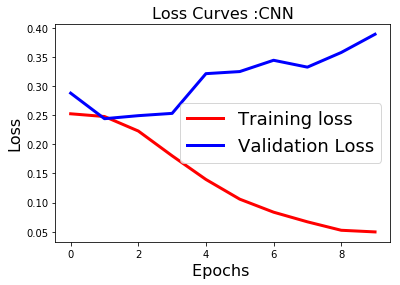

In [19]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()



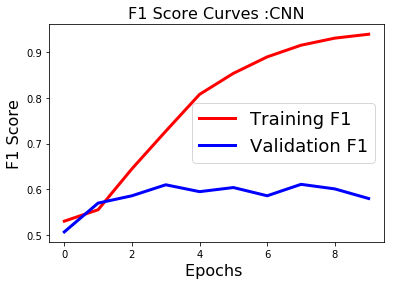

In [22]:
fig3 = plt.figure()
plt.plot(history.history['f1'],'r',linewidth=3.0)
plt.plot(history.history['val_f1'],'b',linewidth=3.0)
plt.legend(['Training F1', 'Validation F1'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('F1 Score',fontsize=16)
plt.title('F1 Score Curves :CNN',fontsize=16)
fig3.savefig('f1_cnn.png')
plt.show()

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         1335100   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 64)           32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 64)           20544     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 64)            20544     
__________

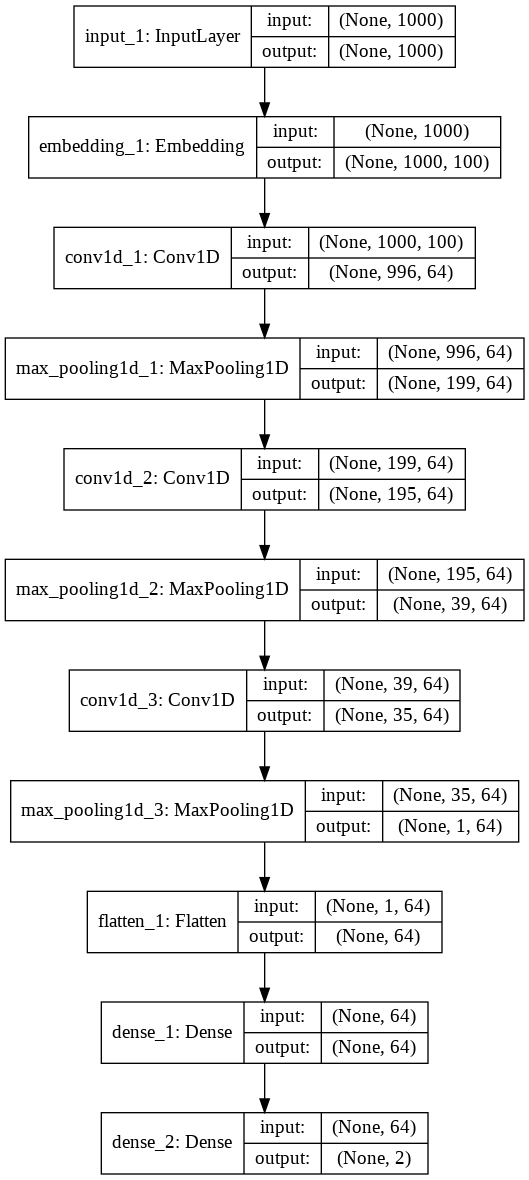

In [25]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')